# We will implement LLM from scratch

## Import the libraries

We will use pytorch and numpy for the AI, ML computations.
Matplotlib for the visuals

In [1]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

/Users/gokdenizgulmez/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params
Here are the configurations for the LLM.

In [2]:
embeddings_dimension = 8 # Also known as "hidden_size" in hugginface, the inner mlp dimension or "intermediete_size" is 8 (embeddings_dimension) * 4 = 32
num_attention_heads = 2
attention_head_size = embeddings_dimension // num_attention_heads # This is the dimension every attention head wil have
num_transformer_blocks = 2
max_context_lenght = 128 # also known as "max_position_embeddings" in hugginface, is the maximum of tokens the llm can process
vocab_size = 0 # Set it to zero because it's going to update it later

### This is only for creating the Plot to visualize the embeddings

In [27]:
def createPlot(nums, xlabel = "Embedding Dimensions", title = "Embeddings Visualization"):
    # Convert embeddings to numpy for visualization
    embeddings_np = nums.detach().numpy()

    # Get dimensions
    embeddings_dimension = embeddings_np.shape[1]
    tokenized_input_length = embeddings_np.shape[0]
    tokenized_input = list(range(tokenized_input_length))

    # Plotting embeddings
    fig, ax = plt.subplots(figsize=(25, 5))  # Increase figure size for bigger squares
    cax = ax.matshow(embeddings_np, aspect='auto', cmap='viridis')

    # Add color bar for reference
    fig.colorbar(cax)

    # Set labels
    ax.set_xticks(np.arange(embeddings_dimension))
    ax.set_yticks(np.arange(tokenized_input_length))
    ax.set_xticklabels([f'Dim {i}' for i in range(embeddings_dimension)])
    ax.set_yticklabels([f'Token {i}' for i in tokenized_input])

    # Rotate the tick labels and set their alignment
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel("labelpad=Tokens")

    # Adding numerical values to the plot
    for i in range(tokenized_input_length):
        for j in range(embeddings_dimension):
            text = ax.text(j, i, f'{embeddings_np[i, j]:.2f}', ha='center', va='center', color='white')

    plt.title(title)
    plt.show()

# Tokenisation

Here we will create a simple Character-Level Tokenizer and the input/training text

Where "S" is the Start of sequence SOS Token
Where "E" is the End of sequence EOS Token

In [4]:
input_text = "SThis is a input textE" # Because its a character leverl tokenizer the SOS is: S and the EOS is: E

# Here we create the Tokenizer
chars = sorted(list(set(input_text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
tokenize = lambda s: [stoi[c] for c in s] # tokenizer: take a string, output a list of integers
detokenize = lambda l: ''.join([itos[i] for i in l]) # detokenizer: take a list of integers, output a string

In [11]:
tokenized_input = tokenize(input_text)
eos_token = tokenized_input[-1]
sos_token = tokenized_input[0]

print(f"New updated vocab size: {vocab_size}")
print(f"sos_token: {sos_token}")
print(f"eos_token: {eos_token}")
print(f"The tokenized Text (as a normal array): {tokenized_input}")
print(f"The context size of the current input text is: {len(tokenized_input)}")
print(f"The detokenized Tensor: \"{detokenize(tokenized_input)}\"")
print(f"As you can see the space token is the number. {tokenized_input[4]}")

New updated vocab size: 14
sos_token: 2
eos_token: 1
The tokenized Text (as a normal array): [2, 3, 6, 7, 10, 0, 7, 10, 0, 4, 0, 7, 8, 9, 12, 11, 0, 11, 5, 13, 11, 1]
The context size of the current input text is: 22
The detokenized Tensor: "SThis is a input textE"
As you can see the space token is the number. 10


## Embeddings Layer

This will give out multidimensional embeddings (a lot of numbers) that represents the given Tokens.

In [25]:
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embeddings_dimension, padding_idx=eos_token)
token_embeddings = embedding(torch.tensor(tokenized_input))

print(f"The shape is: {token_embeddings.shape}")
print(token_embeddings)

print(f"\nFor example the Embeddings that represent the SOS token are: {token_embeddings[0].tolist()}")

The shape is: torch.Size([22, 8])
tensor([[-0.6646,  0.1882,  0.8341,  1.1428, -0.3379,  0.8278,  0.8962,  0.4133],
        [-0.5876, -0.8960, -1.3760,  0.2757, -1.4228, -0.4383,  0.2696,  0.2506],
        [ 1.0909, -0.5427, -0.1492,  0.9628,  0.4750,  0.2210, -0.1900, -0.1118],
        [-1.6965, -0.4488,  0.3824, -1.3000, -0.6871,  0.0413, -1.0447,  1.1553],
        [ 1.0594, -1.2227,  0.1481,  0.4217,  0.7577,  0.5628, -0.8415, -2.2121],
        [ 0.6902,  0.8535, -0.8243,  1.5590, -0.4160,  0.5460, -1.2349, -0.4190],
        [-1.6965, -0.4488,  0.3824, -1.3000, -0.6871,  0.0413, -1.0447,  1.1553],
        [ 1.0594, -1.2227,  0.1481,  0.4217,  0.7577,  0.5628, -0.8415, -2.2121],
        [ 0.6902,  0.8535, -0.8243,  1.5590, -0.4160,  0.5460, -1.2349, -0.4190],
        [ 0.5184,  0.4570,  0.4492,  1.0205, -0.1365,  0.2431,  0.5108,  0.6997],
        [ 0.6902,  0.8535, -0.8243,  1.5590, -0.4160,  0.5460, -1.2349, -0.4190],
        [-1.6965, -0.4488,  0.3824, -1.3000, -0.6871,  0.0413, -

## Create the Plot for the Embeddings

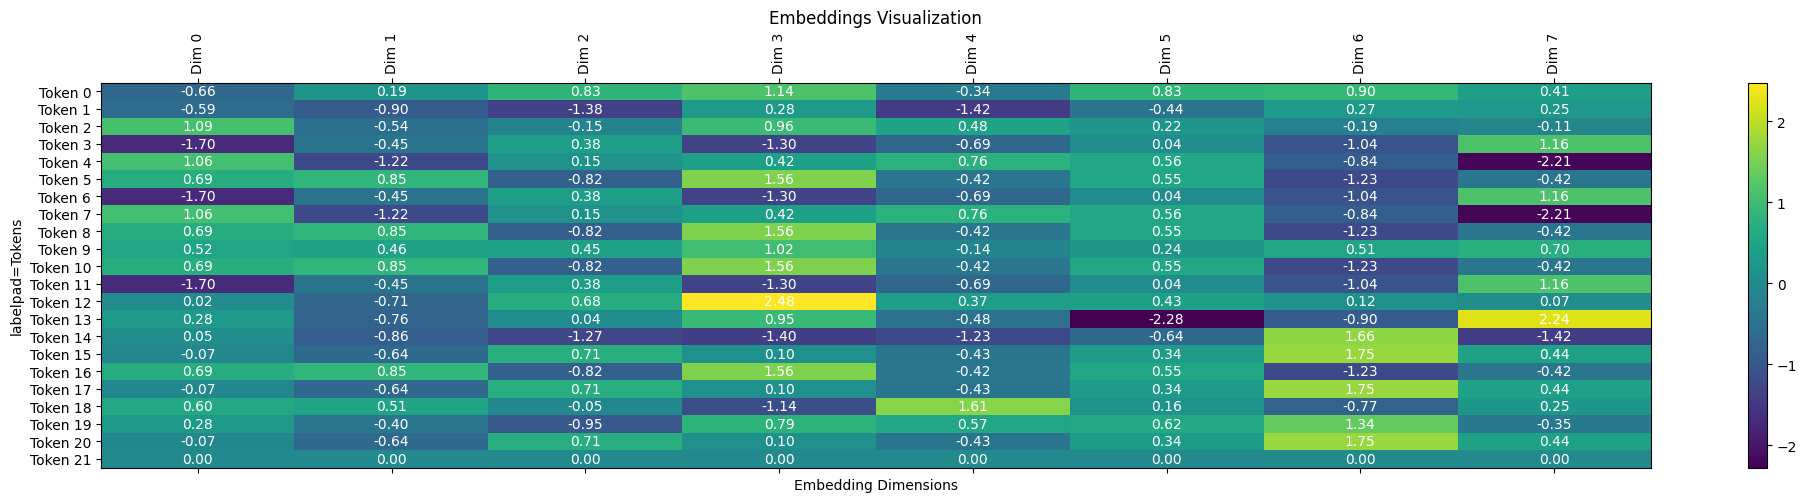

In [28]:
createPlot(token_embeddings)

# LayerNorm

torch.Size([22, 8])


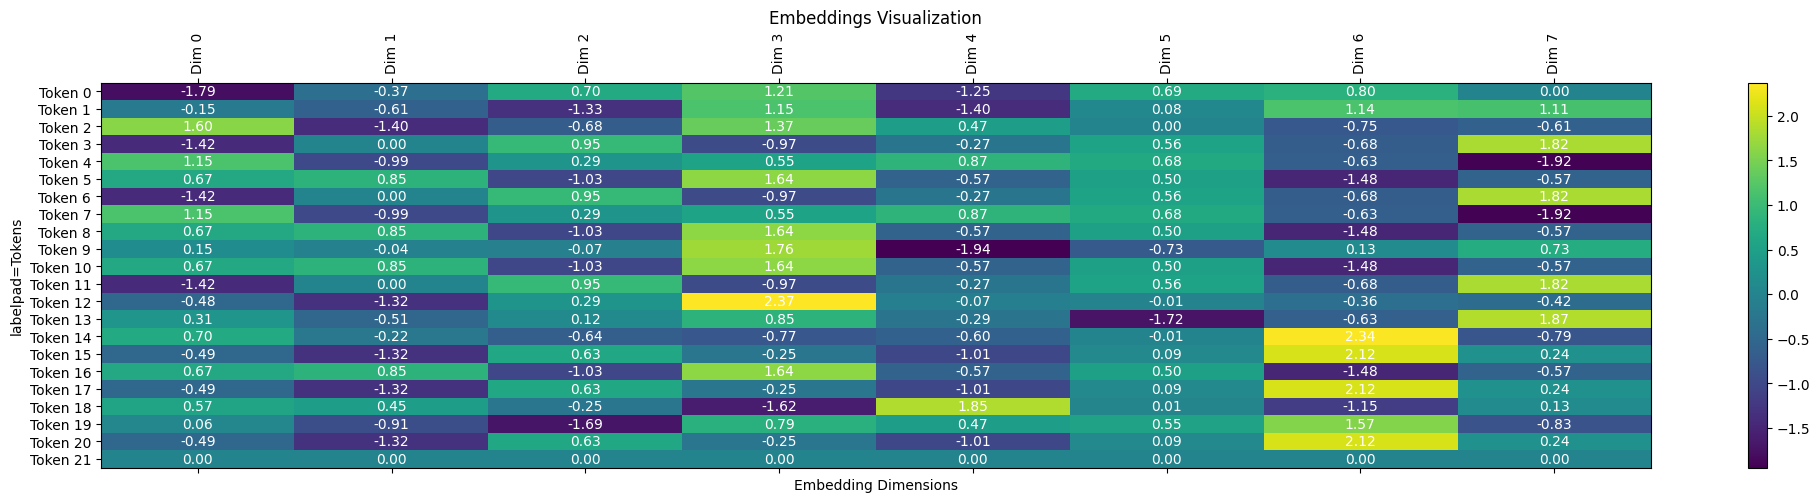

In [29]:
post_attention_layernorm = nn.LayerNorm(embeddings_dimension)
normalized_token_embeddings = post_attention_layernorm(token_embeddings)

print(normalized_token_embeddings.shape)
createPlot(normalized_token_embeddings)

# Multihead Attention

In [ ]:
class AttentionHead(nn.Module):
    """ one head of self-attention """

    def __init__(self):
        super().__init__()
        self.key_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.query_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.value_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(max_context_lenght, max_context_lenght)))

        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        L, D = x.shape

        keys = self.key_proj(x)   # (B,T,hs)
        print("keys beggining")
        createPlot(keys, xlabel="Created Key Projection weights", title="key_proj")
        queries = self.query_proj(x) # (B,T,hs)
        print("queries beggining")
        createPlot(queries, xlabel="Created Key Projection weights", title="key_proj")
        values = self.value_proj(x) # (B,T,hs)
        print("values beggining")
        createPlot(values, xlabel="Created Key Projection weights", title="key_proj")
        
        # ATTENTION START
        # compute attention scores ("affinities")
        wei = queries @ keys.transpose(-2,-1) * keys.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        print("keys and queries multiplied")
        createPlot(wei)
        # Mask the input
        wei = wei.masked_fill(self.tril[:L, :L] == 0, float('-inf')) # (B, T, T)
        print("Masked")
        createPlot(wei)

        wei = F.softmax(wei, dim=-1) # (B, T, T)
        print("Softmaxed")
        createPlot(wei)
        wei = self.dropout(wei)
        print("droped out")
        createPlot(wei)
        # perform the weighted aggregation of the values
        out = wei @ values # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        print("Attentino head output")
        createPlot(out)
        # ATTENTION END

        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead() for _ in range(num_attention_heads)])
        self.out_proj = nn.Linear(attention_head_size * num_attention_heads, embeddings_dimension, bias=False)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        print("concatinated attention outputs")
        createPlot(out)
        print("final output multihaead attention")
        out = self.out_proj(out)
        createPlot(out)
        return self.dropout(out)

In [ ]:
mha = MultiHeadAttention()
print(mha)

In [ ]:
mha_output = mha(embeddings)
print(mha_output.shape)
print(mha_output)

# MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.gate_proj = nn.Linear(embeddings_dimension, 4 * embeddings_dimension, bias=False)
        self.down_proj = nn.Linear(4 * embeddings_dimension, embeddings_dimension, bias=False)
        self.up_proj = nn.Linear(embeddings_dimension, 4 * embeddings_dimension, bias=False)

        self.act_fn = nn.SELU()
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        gate = self.gate_proj(x)
        print("gate_proj")
        createPlot(gate)

        up = self.up_proj(x)
        print("up_proj")
        createPlot(up)

        x = self.act_fn(gate * up)
        print("multiplied and activated")
        createPlot(x)

        down = self.down_proj(x)
        print("down_proj")
        createPlot(down)
        return down

In [ ]:
mlp = MLP()
print(mlp)

In [ ]:
mlp_output = mlp(mha_output)

print(mlp_output.shape)
print(mlp_output)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.attn = MultiHeadAttention()
        self.mlp = MLP()

        self.ln1 = nn.LayerNorm(embeddings_dimension)
        self.ln2 = nn.LayerNorm(embeddings_dimension)

    def forward(self, x):
        attn_o = self.attn(self.ln1(x))
        print("Transformer Block attn output:")
        createPlot(attn_o)

        x = x + attn_o
        print("Transformer Block first Residual Conection:")
        createPlot(x)

        mlp_o = self.mlp(self.ln2(x))
        print("Transformer Block mlp output:")
        createPlot(mlp_o)

        x = x + mlp_o
        print("Transformer Block second Residual Conection and final Output:")
        createPlot(x)
        return x

In [ ]:
transformer_block = TransformerBlock()
print(transformer_block)

In [ ]:
transformer_block(embeddings)

# Creating the full model

In [ ]:
class LlamaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer_blocks = nn.Sequential(*[TransformerBlock() for _ in range(num_transformer_blocks)])
        self.ln_f = nn.LayerNorm(embeddings_dimension)
        self.lm_head = nn.Linear(embeddings_dimension, vocab_size)

    def forward(self, x, targets=None):
        x = self.transformer_blocks(x) # (B,T,C)
        print(f"output transformer blocks:")
        createPlot(x)

        x = self.ln_f(x) # (B,T,C)
        print(f"layer norm:")
        createPlot(x)

        logits = self.lm_head(x) # (B,T,vocab_size)
        print(f"output lm heads (logits):")
        createPlot(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

In [ ]:
model = LlamaModel()
print(model)

## Forward Pass the created embeddings through the Llama

In [ ]:
logits, loss = model(embeddings)

# so the outut of the transformer is the shape torch.Size([22, 14]) the input was torch.Size([22, 13]) the last layer in the shape is the next generated token

In [ ]:
print(logits)
print(loss) # Because its not training it will output "None"

# Inference

In [ ]:
print(logits.shape)

# focus only on the last time step eg the last embeddings layer
last_logits = logits[-1, :] # becomes (D)

print(last_logits)
createPlot(last_logits)

# apply softmax to get probabilities
probs = F.softmax(last_logits, dim=-1) # (B, C)

# sample from the distribution
next_token = torch.multinomial(probs, num_samples=1) # (B, 1)

print(next_token)

# Detokenize the generated output Token

In [ ]:
print(detokenize(next_token.tolist()))

In [ ]:
all_tokens = []

print(logits.shape)

for i in range(10):
    # focus only on the last time step eg the last embeddings layer
    last_logits = logits[-1, :] # becomes (D)
    print(f"last logit embeddings{last_logits}")
    # apply softmax to get probabilities
    probs = F.softmax(last_logits, dim=-1) # (B, C)
    # sample from the distribution
    next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
    all_tokens.append(next_token.item())
    print(next_token)

In [ ]:
print(all_tokens)
print(detokenize(all_tokens))

# All in one

In [ ]:
class AttentionHead(nn.Module):
    """ one head of self-attention """

    def __init__(self):
        super().__init__()
        self.key_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.query_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.value_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(max_context_lenght, max_context_lenght)))

        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        L, _ = x.shape

        keys = self.key_proj(x)   # (B,T,hs)
        queries = self.query_proj(x) # (B,T,hs)
        values = self.value_proj(x) # (B,T,hs)
        
        # ATTENTION START
        # compute attention scores ("affinities")
        wei = queries @ keys.transpose(-2,-1) * keys.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:L, :L] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        out = wei @ values # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        # ATTENTION END
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead() for _ in range(num_attention_heads)])
        self.out_proj = nn.Linear(attention_head_size * num_attention_heads, embeddings_dimension, bias=False)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.out_proj(out)
        return self.dropout(out)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.gate_proj = nn.Linear(embeddings_dimension, 4 * embeddings_dimension, bias=False)
        self.down_proj = nn.Linear(4 * embeddings_dimension, embeddings_dimension, bias=False)
        self.up_proj = nn.Linear(embeddings_dimension, 4 * embeddings_dimension, bias=False)
        self.act_fn = nn.SELU()

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x) * self.up_proj(x)))
    
class TransformerBlock(nn.Module):
    def __init__(self):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.attn = MultiHeadAttention()
        self.mlp = MLP()

        self.ln1 = nn.LayerNorm(embeddings_dimension)
        self.ln2 = nn.LayerNorm(embeddings_dimension)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x
    
class LlamaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embeddings_dimension, padding_idx=eos_token)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock() for _ in range(num_transformer_blocks)])
        self.ln_f = nn.LayerNorm(embeddings_dimension)
        self.lm_head = nn.Linear(embeddings_dimension, vocab_size)

    def forward(self, x, targets=None):
        x = self.embeddings(x)
        x = self.transformer_blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last max_context_size tokens
            idx_cond = idx[:, -max_context_lenght:]
            # get the predictions
            new_logits, loss = self(idx_cond)
            # focus only on the last time step
            new_logits = new_logits[-1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(new_logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
llama = LlamaModel()
print(sum(p.numel() for p in llama.parameters())/1e6, 'M parameters')
print(llama)

In [ ]:
out = llama.generate(torch.tensor(tokenized_input), max_new_tokens=5)[0].tolist()
print(out)